In [8]:
! pip install -q kaggle

In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"zipkaggle2","key":"ff0712558b46c6504f0a74bfc8871818"}'}

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [11]:
! kaggle datasets download -d mssmartypants/water-quality

water-quality.zip: Skipping, found more recently modified local copy (use --force to force download)


In [108]:
from IPython.core.display import clear_output
!unzip '/content/water-quality.zip' -d '/content/water-quality'
clear_output()

In [13]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [109]:
df = pd.read_csv('/content/water-quality/waterQuality1.csv')
df.head()

,aluminium,ammonia,arsenic,barium,cadmium,chloramine,chromium,copper,flouride,bacteria,...,lead,nitrates,nitrites,mercury,perchlorate,radium,selenium,silver,uranium,is_safe
0,1.65,9.08,0.04,2.85,0.007,0.35,0.83,0.17,0.05,0.20,...,0.054,16.08,1.13,0.007,37.75,6.78,0.08,0.34,0.02,1
1,2.32,21.16,0.01,3.31,0.002,5.28,0.68,0.66,0.90,0.65,...,0.100,2.01,1.93,0.003,32.26,3.21,0.08,0.27,0.05,1
2,1.01,14.02,0.04,0.58,0.008,4.24,0.53,0.02,0.99,0.05,...,0.078,14.16,1.11,0.006,50.28,7.07,0.07,0.44,0.01,0
3,1.36,11.33,0.04,2.96,0.001,7.23,0.03,1.66,1.08,0.71,...,0.016,1.41,1.29,0.004,9.12,1.72,0.02,0.45,0.05,1
4,0.92,24.33,0.03,0.20,0.006,2.67,0.69,0.57,0.61,0.13,...,0.117,6.74,1.11,0.003,16.90,2.41,0.02,0.06,0.02,1


In [110]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7999 entries, 0 to 7998
Data columns (total 21 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   aluminium    7999 non-null   float64
 1   ammonia      7999 non-null   object 
 2   arsenic      7999 non-null   float64
 3   barium       7999 non-null   float64
 4   cadmium      7999 non-null   float64
 5   chloramine   7999 non-null   float64
 6   chromium     7999 non-null   float64
 7   copper       7999 non-null   float64
 8   flouride     7999 non-null   float64
 9   bacteria     7999 non-null   float64
 10  viruses      7999 non-null   float64
 11  lead         7999 non-null   float64
 12  nitrates     7999 non-null   float64
 13  nitrites     7999 non-null   float64
 14  mercury      7999 non-null   float64
 15  perchlorate  7999 non-null   float64
 16  radium       7999 non-null   float64
 17  selenium     7999 non-null   float64
 18  silver       7999 non-null   float64
 19  uraniu

**Подготовка набора данных**

In [111]:
df["is_safe"].value_counts()

0        7084
1         912
#NUM!       3
Name: is_safe, dtype: int64

In [112]:
#Удалим из датасета записи с #NUM! в is_safe
values = ["#NUM!"]
df = df[df["is_safe"].isin (values) == False ]

In [113]:
df["is_safe"].value_counts()

0    7084
1     912
Name: is_safe, dtype: int64

In [114]:
#Перевод is_safe и ammonia в числовой формат
df[["ammonia", "is_safe"]] = df[["ammonia", "is_safe"]].apply(pd.to_numeric)

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7996 entries, 0 to 7998
Data columns (total 21 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   aluminium    7996 non-null   float64
 1   ammonia      7996 non-null   float64
 2   arsenic      7996 non-null   float64
 3   barium       7996 non-null   float64
 4   cadmium      7996 non-null   float64
 5   chloramine   7996 non-null   float64
 6   chromium     7996 non-null   float64
 7   copper       7996 non-null   float64
 8   flouride     7996 non-null   float64
 9   bacteria     7996 non-null   float64
 10  viruses      7996 non-null   float64
 11  lead         7996 non-null   float64
 12  nitrates     7996 non-null   float64
 13  nitrites     7996 non-null   float64
 14  mercury      7996 non-null   float64
 15  perchlorate  7996 non-null   float64
 16  radium       7996 non-null   float64
 17  selenium     7996 non-null   float64
 18  silver       7996 non-null   float64
 19  uraniu

In [115]:
normalized_df=(df-df.min())/(df.max()-df.min())#Нормализация

**Нейронная сеть**

In [23]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, TensorDataset, DataLoader

In [116]:
class MyDataset(Dataset):
  def __init__(self, data, targets, transform=None):
      self.data = torch.Tensor(np.array(data)).float()
      self.targets = torch.LongTensor(np.array(targets))
      self.transform = transform

  def __getitem__(self, index):
      x = self.data[index]
      y = self.targets[index]
      return x, y

  def __len__(self):
      return len(self.data)

In [117]:
class net(nn.Module):
  def __init__(self):
    super().__init__()
    self.fc1 = nn.Linear(20, 64)
    self.fc2 = nn.Linear(64, 16)
    self.fc3 = nn.Linear(16, 6)
    self.bn1 = nn.BatchNorm1d(64)
    self.bn2 = nn.BatchNorm1d(16)
    self.activation = nn.LeakyReLU(inplace=True)

  def forward(self, x):
    # 1-й слой
    x=self.fc1(x)
    x=self.activation(x)
    x=self.bn1(x)
    # 2-й слой
    x=self.fc2(x)
    x=self.activation(x)
    x=self.bn2(x)
    # 3-й слой
    x=self.fc3(x)
    return x

**Обучение**

In [26]:
from sklearn.model_selection import train_test_split

In [131]:
y = normalized_df['is_safe']
x = normalized_df.drop(columns='is_safe')
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=5)

In [132]:
trainDf = MyDataset(X_train, y_train)
testDf = MyDataset(X_test, y_test)

In [120]:
batch_size=16

In [133]:
train_loader = DataLoader(trainDf, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(testDf, batch_size, shuffle=True)

In [122]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [134]:
model=net()
model.to(device);

In [33]:
! pip install torchinfo

In [135]:
from torchinfo import summary
summary(model, input_size=(1, 20))

Layer (type:depth-idx)                   Output Shape              Param #
net                                      [1, 6]                    --
├─Linear: 1-1                            [1, 64]                   1,344
├─LeakyReLU: 1-2                         [1, 64]                   --
├─BatchNorm1d: 1-3                       [1, 64]                   128
├─Linear: 1-4                            [1, 16]                   1,040
├─LeakyReLU: 1-5                         [1, 16]                   --
├─BatchNorm1d: 1-6                       [1, 16]                   32
├─Linear: 1-7                            [1, 6]                    102
Total params: 2,646
Trainable params: 2,646
Non-trainable params: 0
Total mult-adds (M): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.01
Estimated Total Size (MB): 0.01

In [136]:
#функция ошибки
criterion = nn.CrossEntropyLoss()
#оптимизатор
optimizer=torch.optim.Adam(model.parameters())

In [36]:
! pip install pytorch-ignite;

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 272.4/272.4 kB 2.1 MB/s eta 0:00:00


In [137]:
from ignite.engine import Engine, _prepare_batch
from ignite.engine import create_supervised_trainer
from ignite.engine import Events
from ignite.engine import create_supervised_evaluator
from ignite.metrics import Loss, Accuracy

train = {'accuracy':[],'loss':[]}
test = {'accuracy':[],'loss':[]}
metrics = {
    'accuracyCalc': Accuracy(),
    'lossFunc': Loss(criterion)}

trainer = create_supervised_trainer(model, optimizer, criterion, device)
train_evaluator = create_supervised_evaluator(model, metrics=metrics, device=device)
test_evaluator = create_supervised_evaluator(model, metrics=metrics, device=device)

@trainer.on(Events.EPOCH_COMPLETED)
def compute_and_display_offline_train_metrics(engine):
    metrics = train_evaluator.run(train_loader).metrics
    print("Эпоха №{}".format(engine.state.epoch))
    print("Обучение:  (Ошибка: {:.4f}  Точность: {:.4f})"
          .format(metrics['lossFunc'], metrics['accuracyCalc']))
    train['accuracy'].append(metrics['accuracyCalc'])
    train['loss'].append(metrics['lossFunc'])

@trainer.on(Events.EPOCH_COMPLETED)
def compute_and_display_test_metrics(engine):
    metrics = test_evaluator.run(test_loader).metrics
    print("Тест:  (Ошибка: {:.4f}  Точность: {:.4f})"
          .format(metrics['lossFunc'], metrics['accuracyCalc']))
    print("")
    test['accuracy'].append(metrics['accuracyCalc'])
    test['loss'].append(metrics['lossFunc'])

res = trainer.run(train_loader, max_epochs=50)

Эпоха №1
Обучение:  (Ошибка: 0.3301  Точность: 0.9162)
Тест:  (Ошибка: 0.3610  Точность: 0.9137)

Эпоха №2
Обучение:  (Ошибка: 0.2031  Точность: 0.9262)
Тест:  (Ошибка: 0.2206  Точность: 0.9200)

Эпоха №3
Обучение:  (Ошибка: 0.1825  Точность: 0.9304)
Тест:  (Ошибка: 0.2051  Точность: 0.9206)

Эпоха №4
Обучение:  (Ошибка: 0.1556  Точность: 0.9439)
Тест:  (Ошибка: 0.1820  Точность: 0.9356)

Эпоха №5
Обучение:  (Ошибка: 0.1428  Точность: 0.9481)
Тест:  (Ошибка: 0.1753  Точность: 0.9344)

Эпоха №6
Обучение:  (Ошибка: 0.1292  Точность: 0.9531)
Тест:  (Ошибка: 0.1584  Точность: 0.9406)

Эпоха №7
Обучение:  (Ошибка: 0.1266  Точность: 0.9533)
Тест:  (Ошибка: 0.1577  Точность: 0.9437)

Эпоха №8
Обучение:  (Ошибка: 0.1161  Точность: 0.9539)
Тест:  (Ошибка: 0.1509  Точность: 0.9456)

Эпоха №9
Обучение:  (Ошибка: 0.1143  Точность: 0.9581)
Тест:  (Ошибка: 0.1459  Точность: 0.9450)

Эпоха №10
Обучение:  (Ошибка: 0.1092  Точность: 0.9581)
Тест:  (Ошибка: 0.1485  Точность: 0.9469)

Эпоха №11
Обучение:

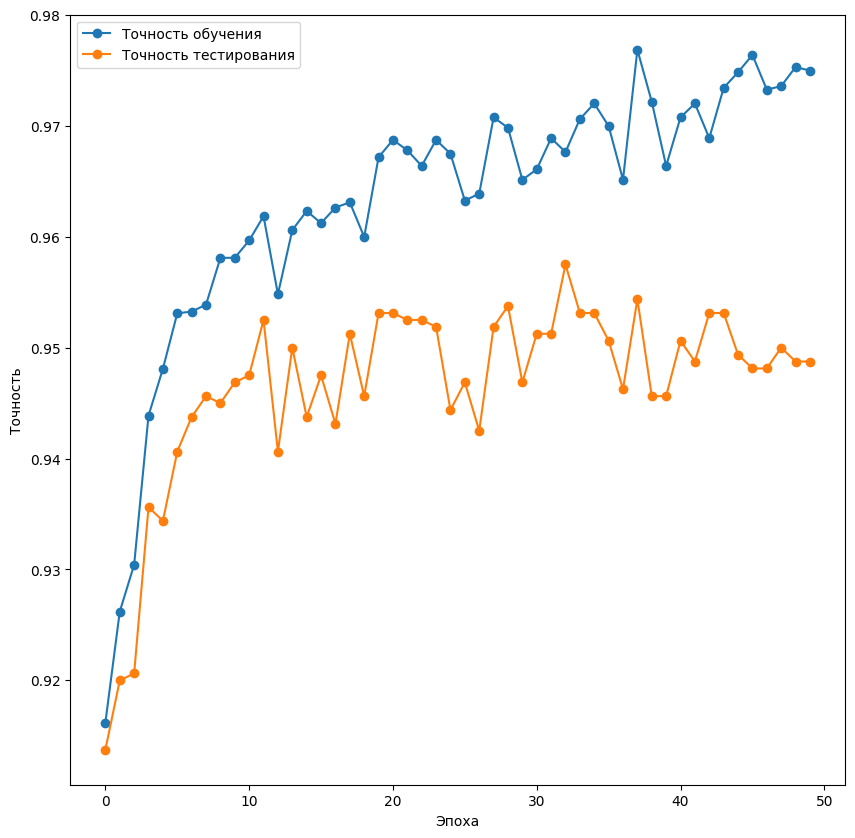

In [140]:
plt.plot(train['accuracy'],'-o',label="Точность обучения")
plt.plot(test['accuracy'],'-o',label="Точность тестирования")
plt.rcParams["figure.figsize"] = (10,10)
plt.xlabel('Эпоха')
plt.ylabel('Точность')
plt.legend(frameon=True)
plt.show()

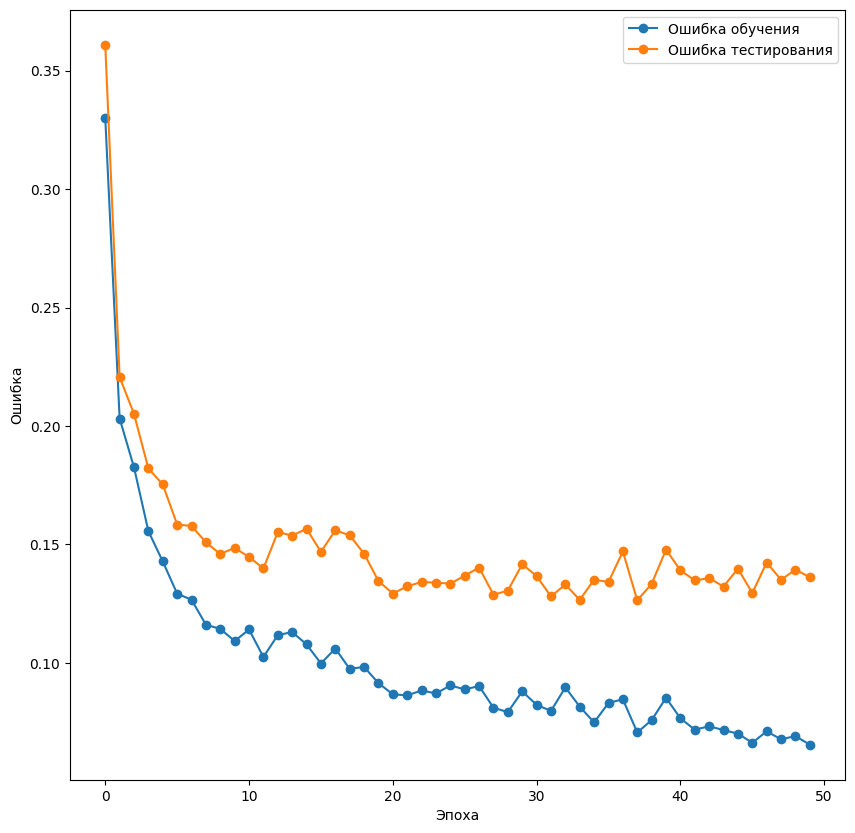

In [144]:
plt.plot(train['loss'],'-o',label="Ошибка обучения")
plt.plot(test['loss'],'-o',label="Ошибка тестирования")
plt.rcParams["figure.figsize"] = (10,10)
plt.xlabel('Эпоха')
plt.ylabel('Ошибка')
plt.legend(frameon=True)
plt.show()